In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Input, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix

In [3]:
!wget https://www.dropbox.com/scl/fi/ln64xjqlwd4665u9sp2bq/Full_Dataset.rar?rlkey=g5aa4zefy2xpj98n3x8ihjcp2&st=bg907w5p&dl=0
!mv Full_Dataset.rar?rlkey=g5aa4zefy2xpj98n3x8ihjcp2 Full_Dataset.rar
!unrar x /content/Full_Dataset.rar


Streaming output truncated to the last 5000 lines.
Extracting  Full_Dataset/55.txt                                           72%  OK 
Extracting  Full_Dataset/550.txt                                          72%  OK 
Extracting  Full_Dataset/5500.txt                                         72%  OK 
Extracting  Full_Dataset/5501.txt                                         72%  OK 
Extracting  Full_Dataset/5502.txt                                         72%  OK 
Extracting  Full_Dataset/5503.txt                                         72%  OK 
Extracting  Full_Dataset/5504.txt                                         72%  OK 
Extracting  Full_Dataset/5505.txt                                         72%  OK 
Extracting  Full_Dataset/5506.txt                                         72%  OK 
Extracting  Full_Dataset/5507.txt                                         72%  OK 
Extracting  Full_Dataset/5508

In [4]:
!wget https://raw.githubusercontent.com/HaniehP/PersianNER/refs/heads/master/glove300d.txt.zip

--2024-12-04 11:22:53--  https://raw.githubusercontent.com/HaniehP/PersianNER/refs/heads/master/glove300d.txt.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53542816 (51M) [application/zip]
Saving to: ‘glove300d.txt.zip’

glove300d.txt.zip   100%[===================>]  51.06M   282MB/s    in 0.2s    

2024-12-04 11:22:55 (282 MB/s) - ‘glove300d.txt.zip’ saved [53542816/53542816]



In [5]:
!unzip /content/glove300d.txt.zip

Archive:  /content/glove300d.txt.zip
  inflating: glove300d.txt           


In [6]:
# Path to the folder containing the text files
folder_path = 'Full_Dataset'

# Initialize empty lists to store text and labels
raw_train_ds = []
labels_ds = []

# List the files in the folder
files = os.listdir(folder_path)

# Iterate over the first 10 files
for file_name in files:
    # Construct the full path to the file
    file_path = os.path.join(folder_path, file_name)

    # Open the text file in read mode with UTF-8 encoding
    with open(file_path, 'r', encoding='utf-8') as file:
        # Initialize empty strings to store text and label for current file
        text = ''
        label = []

        # Iterate through each line in the file
        for line in file:
            # Get the last character of the line
            last_char = line.strip()[-1:]
            # Append the last character to the label
            label.append(int(last_char))

            # Get the rest of the line (excluding the last character)
            rest_of_line = line.strip()[:-1]
            # Append the rest of the line to the text
            text += rest_of_line

        # Append the text and label for the current file to the lists
        raw_train_ds.append(text)
        labels_ds.append(label)

In [7]:
print(len(raw_train_ds),len(labels_ds))

18269 18269


In [8]:
train_size = 0.8

size = len(raw_train_ds)

train_samples = int(size * train_size)

x_train, y_train = raw_train_ds[:train_samples], labels_ds[:train_samples]
x_valid, y_valid = raw_train_ds[train_samples:], labels_ds[train_samples:]

In [9]:
print("Training set:", x_train[100] ,"\n", y_train[100])

Training set: در یادداشتی در همین مورد می خوانیم : « هواداران سویا دلیل محکمی برای خوشحال بودن دارند .  
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [10]:
# Load pre-trained GloVe embeddings
embedding_index = {}
with open('glove300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        try:
            values = line.strip().split()  # Strip whitespace from the line before splitting
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coefs
        except ValueError:
            # Print the problematic line for debugging
            print(f"Skipping line: {line.strip()}")
            # Or, you can log the error to a file for later analysis
            # with open('error_log.txt', 'a') as error_log:
            #     error_log.write(f"Error processing line: {line.strip()}\n")
            continue  # Skip to the next line

Skipping line: می شود 0.045234 -0.138007 -0.063701 -0.034637 0.233488 0.058645 0.002620 -0.086740 -0.024940 0.062331 0.009055 0.013705 0.072000 -0.146489 -0.088941 0.006299 -0.054138 -0.108904 0.026761 0.019836 0.012520 -0.041259 0.024981 0.034578 0.068951 0.063897 0.007285 0.018705 0.100338 0.098320 -0.093266 0.062570 -0.019398 -0.002897 0.059556 0.005894 -0.033084 -0.001885 0.015043 -0.074675 0.015635 -0.000991 -0.109001 0.056794 -0.070647 -0.211876 0.164263 -0.017861 -0.055614 0.021011 -0.081024 0.023109 0.014485 0.012965 -0.068300 -0.093327 -0.029356 0.002263 0.075544 -0.038906 0.141408 -0.034422 -0.012839 0.001632 -0.038353 0.079242 0.047423 0.020115 0.005793 0.115049 0.026519 -0.038778 -0.082163 0.009444 0.056726 -0.066936 0.003078 0.022778 0.013269 0.029521 0.018870 0.026928 -0.156912 -0.005770 0.050307 -0.000234 0.072230 0.069852 0.052378 -0.097546 0.074582 0.101277 -0.062669 0.004643 0.093285 0.034802 0.067362 0.098507 0.000117 -0.002409 -0.020236 0.028680 0.099104 -0.112732 0

In [11]:
# Create TextVectorization layer
max_tokens = 10000
output_sequence_length = 50
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_sequence_length
)
vectorize_layer.adapt(x_train)

In [12]:
# Apply vectorization and pad labels
x_train_vectorized = vectorize_layer(x_train)
x_valid_vectorized = vectorize_layer(x_valid)

y_train_padded = tf.keras.preprocessing.sequence.pad_sequences(y_train, maxlen=output_sequence_length, padding='post')
y_valid_padded = tf.keras.preprocessing.sequence.pad_sequences(y_valid, maxlen=output_sequence_length, padding='post')


In [13]:
# Create embedding matrix
vocab = vectorize_layer.get_vocabulary()
word_index = {word: i for i, word in enumerate(vocab)}
embedding_dim = 300
embedding_matrix = np.zeros((len(vocab), embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [14]:
# Define model parameters
num_classes = len(set([label for sublist in y_train for label in sublist]))

In [15]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Input, Dropout, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import LearningRateScheduler

In [17]:
# Define the input layer
input = Input(shape=(output_sequence_length,))  # Shape of the input sequence

# Embedding Layer with GloVe embeddings
model = Embedding(input_dim=len(vocab),
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=output_sequence_length,
                  trainable=False)(input)

# Dropout Layer for regularization
model = Dropout(0.2)(model)  # Increase dropout for regularization

# First Bidirectional LSTM Layer
model = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.2))(model)

# Second Bidirectional LSTM Layer
model = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.2))(model)

# Adding a Dense Layer to learn more features
model = Dropout(0.3)(model)
model = TimeDistributed(Dense(num_classes, activation='softmax'))(model)  # TimeDistributed for sequence labeling

# Compile the model with AdamW optimizer
ner_model = Model(inputs=input, outputs=model)


In [18]:
# Compile the model with AdamW optimizer
ner_model = Model(inputs=input, outputs=model)
ner_model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy')

In [19]:
# Print the model summary
ner_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 50, 300)             │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 300)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 128)             │         186,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 50, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 50, 2)               │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,285,954 (12.53 MB)

 Trainable params: 285,954 (1.09 MB)

 Non-trainable params: 3,000,000 (11.44 MB)

In [20]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix

# Define a custom callback for precision, recall, F1-score, and accuracy per sentence
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_x, val_y = self.validation_data
        y_pred = self.model.predict(val_x)

        # Convert predictions to class labels
        y_pred_classes = y_pred.argmax(axis=-1)

        # Flatten the arrays for token-level metrics
        val_y_flat = val_y.flatten()
        y_pred_flat = y_pred_classes.flatten()

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(val_y_flat, y_pred_flat)
        TP = conf_matrix[1, 1]
        FP = conf_matrix[0, 1]
        FN = conf_matrix[1, 0]

        # Precision, Recall, and F1-Score for Class 1
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        # Calculate sentence-level accuracy
        correct_sentences = np.all(val_y == y_pred_classes, axis=1)  # Compare token-level labels for each sentence
        sentence_accuracy = np.mean(correct_sentences)  # Percentage of completely correct sentences

        # Print metrics
        print(f"\nEpoch {epoch + 1}:")
        print(f"Precision (Class 1): {precision:.4f}, Recall (Class 1): {recall:.4f}, F1-Score (Class 1): {f1:.4f}")
        print(f"Sentence-Level Accuracy: {sentence_accuracy:.4f}")


In [21]:
# Train the model
batch_size = 64
epochs = 16  # Increased number of epochs for better training

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_vectorized, y_train_padded)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid_vectorized, y_valid_padded)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

metrics_callback = MetricsCallback(validation_data=(x_valid_vectorized, y_valid_padded))

history = ner_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    verbose=1,
    callbacks=[metrics_callback]
)

Epoch 1/16
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step

Epoch 1:
Precision (Class 1): 0.5734, Recall (Class 1): 0.1892, F1-Score (Class 1): 0.2845
Sentence-Level Accuracy: 0.7455
229/229 ━━━━━━━━━━━━━━━━━━━━ 98s 365ms/step - loss: 0.0976 - val_loss: 0.0349
Epoch 2/16
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step

Epoch 2:
Precision (Class 1): 0.6866, Recall (Class 1): 0.3595, F1-Score (Class 1): 0.4719
Sentence-Level Accuracy: 0.7887
229/229 ━━━━━━━━━━━━━━━━━━━━ 82s 359ms/step - loss: 0.0338 - val_loss: 0.0306
Epoch 3/16
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step

Epoch 3:
Precision (Class 1): 0.7008, Recall (Class 1): 0.4169, F1-Score (Class 1): 0.5228
Sentence-Level Accuracy: 0.8008
229/229 ━━━━━━━━━━━━━━━━━━━━ 85s 371ms/step - loss: 0.0299 - val_loss: 0.0288
Epoch 4/16
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step

Epoch 4:
Precision (Class 1): 0.7212, Recall (Class 1): 0.4487, F1-Score (Class 1): 0.5532
Sentence-Level Accuracy: 0.8128
229/229 ━━━━━━━━━━━━━━━━━━━━ 84s 366ms/step - loss: 0.02

In [22]:
# Predict on validation set
y_pred = ner_model.predict(x_valid_vectorized).argmax(axis=-1)

# Flatten the arrays for token-level metrics
val_y_flat = y_valid_padded.flatten()
y_pred_flat = y_pred.flatten()

# Calculate confusion matrix
conf_matrix = confusion_matrix(val_y_flat, y_pred_flat)
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

# Precision, Recall, and F1-Score for Class 1
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Sentence-Level Accuracy
correct_sentences = np.all(y_valid_padded == y_pred, axis=1)  # Check if all tokens in each sentence are correct
sentence_accuracy = np.mean(correct_sentences)  # Percentage of completely correct sentences

# Print metrics
print(f'Validation Precision (Class 1): {precision:.4f}')
print(f'Validation Recall (Class 1): {recall:.4f}')
print(f'Validation F1-Score (Class 1): {f1:.4f}')
print(f'Sentence-Level Accuracy: {sentence_accuracy:.4f}')

115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step
Validation Precision (Class 1): 0.7735
Validation Recall (Class 1): 0.5648
Validation F1-Score (Class 1): 0.6528
Sentence-Level Accuracy: 0.8385


In [23]:
# Define the function to preprocess and predict NER tags for a single input string
def predict_ner_tags(input_string, vectorize_layer, model, max_length=50):
    # Tokenize the input string
    tokenized_input = input_string.split()

    # Vectorize the tokenized input
    input_vectorized = vectorize_layer(' '.join(tokenized_input))

    # Pad the vectorized input to the same length as used during training
    input_vectorized = tf.keras.preprocessing.sequence.pad_sequences([input_vectorized], maxlen=max_length, padding='post')

    # Make predictions
    predictions = model.predict(input_vectorized)

    # Post-process predictions to get the labels
    predicted_labels = tf.argmax(predictions, axis=-1).numpy()[0]

    # Only show labels for the original input length
    return list(zip(tokenized_input, predicted_labels[:len(tokenized_input)]))

In [24]:
# Example usage of the prediction function
input_sentences = [
    "مهدی صالحی، وزیر صنعت، معدن و تجارت، امروز به دیدار علیرضا رحیمی مدیر فناوری اطلاعاتی رفت.",
    "دکتر حسینی، استاد دانشگاه تهران، در مورد تکنیک‌های یادگیری عمیق مقاله‌ای منتشر کرد.",
    "فرزاد نوری، مدیر عامل شرکت ارتباطات پیشرفته، از آغاز طرح جدید خود خبر داد.",
    "دانیال نیکو، بازیکن تیم ملی فوتبال ایران، به خاطر حضور در مسابقات بین‌المللی تشویق شد.",
    "سوسن افشار، بازیگر معروف سینما و تلویزیون، امشب در برنامه خندوانه حاضر خواهد شد.",
    "حسن روحانی ، به روحانی محل ، رشوه داد .",
]
for input_string in input_sentences:
    predicted_ner_tags = predict_ner_tags(input_string, vectorize_layer, ner_model)

    # Print the results
    for word, label in predicted_ner_tags:
        print(f"{word}: {label}")
    print()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
مهدی: 1
صالحی،: 1
وزیر: 0
صنعت،: 0
معدن: 0
و: 0
تجارت،: 0
امروز: 0
به: 0
دیدار: 0
علیرضا: 1
رحیمی: 1
مدیر: 0
فناوری: 0
اطلاعاتی: 0
رفت.: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
دکتر: 0
حسینی،: 1
استاد: 0
دانشگاه: 0
تهران،: 0
در: 0
مورد: 0
تکنیک‌های: 0
یادگیری: 0
عمیق: 0
مقاله‌ای: 0
منتشر: 0
کرد.: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
فرزاد: 1
نوری،: 1
مدیر: 0
عامل: 0
شرکت: 0
ارتباطات: 0
پیشرفته،: 0
از: 0
آغاز: 0
طرح: 0
جدید: 0
خود: 0
خبر: 0
داد.: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
دانیال: 1
نیکو،: 1
بازیکن: 0
تیم: 0
ملی: 0
فوتبال: 0
ایران،: 0
به: 0
خاطر: 0
حضور: 0
در: 0
مسابقات: 0
بین‌المللی: 0
تشویق: 0
شد.: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
سوسن: 1
افشار،: 1
بازیگر: 0
معروف: 0
سینما: 0
و: 0
تلویزیون،: 0
امشب: 0
در: 0
برنامه: 0
خندوانه: 0
حاضر: 0
خواهد: 0
شد.: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
حسن: 1
روحانی: 1
،: 0
به: 0
روحانی: 0
محل: 0
،: 0
رشوه: 0
داد: 0
.: 0



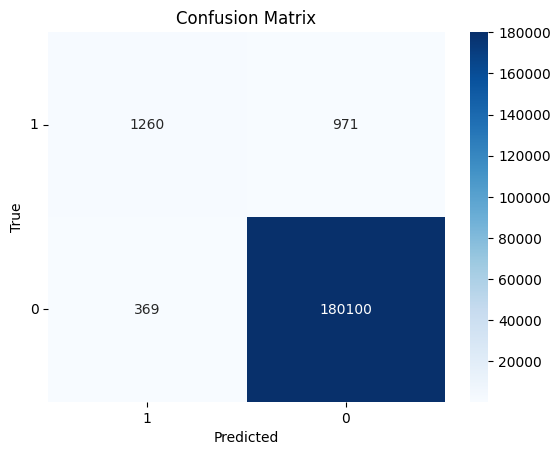

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_true_flat = y_valid_padded.flatten()
y_pred_flat = y_pred.flatten()

# Compute confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)

# Swap rows and columns to change the order
cm = cm[[1, 0], :]  # Swap rows
cm = cm[:, [1, 0]]  # Swap columns

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0.5, 1.5], ['1', '0'])  # Update x-axis labels
plt.yticks([0.5, 1.5], ['1', '0'], rotation=0)  # Update y-axis labels
plt.show()


In [26]:
# Assuming 'vectorize_layer' is your TextVectorization layer
# Add the vectorize_layer to the model architecture
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)  # Assuming input is text (string)
x = vectorize_layer(inputs)  # Apply vectorization
outputs = ner_model(x)  # Pass the vectorized input to the rest of the model

# Create a new model with the vectorize layer
model_with_preprocessing = tf.keras.Model(inputs, outputs)

# Save the model with preprocessing included
model_with_preprocessing.save('ner_model_with_preprocessor_pretrained_embedding.keras', save_format='keras')

# Optionally, zip the model folder
!zip -r /content/ner_model_with_preprocessor_pretrained_embedding.zip /content/ner_model_with_preprocessor_pretrained_embedding.keras

  adding: content/ner_model_with_preprocessor_pretrained_embedding.keras (deflated 17%)
